In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
#from celluloid import Camera
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 14})
import os, sys
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
    
def calcvelocity(rrange,sigma,vdiff,A,vmin):         #Calculate the introduced velocity profile
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,int(nx/2+1))
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vactive*vdiff*np.exp(-I/A)+vmin, I

In [2]:
name = 'Focker-Planck'

amplitude = 1                    #Amplitude, always 1
vmin = 0                         #Min velocity
vmax = 1                         #Max velocity
pxtomum=0.0533e-6               #px to µm [µm/px]
sigma = 70*pxtomum               #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14#*1e12              #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
boundaryradius = pxtomum * 200   #Size of the arena
vactive = 6e-6                      #Active velocity

vdiff = vmax-vmin
nx = 101
nt = 50
tauR = 1
delta_x = 2*boundaryradius/nx
savefolder = '.'

dt = 0.05
videosize = 800        #800, 521, 256, 128
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtprogram = 10e-3
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3
delayincrease = 4

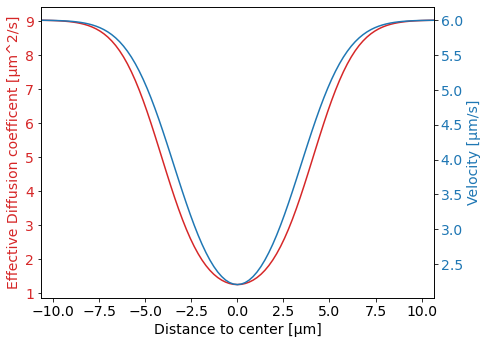

In [3]:
xarray1, varray1, Iarray1 = calcvelocity(boundaryradius,sigma,vdiff,amplitude,vmin)
xarray = np.linspace(-boundaryradius,boundaryradius,nx)
varray = np.zeros(nx)
for i in range(int(nx/2+1)):
    varray[int(nx/2)+i] = varray1[i]
    varray[int(nx/2)-i] = varray1[i]
Darray = D_0 + varray**2*tauR/4

fig, ax = plt.subplots(figsize=(7,5)) 
ax1 = plt.subplot(1,1,1)
color1 = 'tab:red'
ax1.plot(xarray*1e6,Darray*1e12,color=color1)
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Effective Diffusion coefficent [µm^2/s]',color=color1) 
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim([-boundaryradius*1e6,boundaryradius*1e6])
#ax1.set_ylim([0,9.5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'tab:blue'
ax2.plot(xarray*1e6,varray*1e6,color=color2)
ax2.set_ylabel('Velocity [µm/s]',color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
#ax2.set_ylim([0,6.5])

plt.tight_layout() 
plt.savefig('Diffusion coefficent profiles.pdf', format='pdf')
plt.savefig('Diffusion coefficent profiles.svg', format='svg')
plt.show()

In [4]:
length = 10
saveall = np.zeros((nx,length,3))
densitysave = np.zeros(length)
delaywave = np.zeros(length)
check = True; count = int(nx/2)
calctime = 0
for p in range(length):
    start_time = time.time() 
    frames = 1 + 4*p

    check = True
    dtframetransfer = videosize/binning * verticalshift
    dtreadout = (1032/27e6+verticalshift)*videosize/binning
    dtexphalf = flashtime/2
    dttest = flashtime + dtframetransfer + dtreadout
    dtcycle = dt + dtframetransfer
    dttotal = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin + (frames-1)*dtcycle
    if dttest > dt: 
        check = False
        dtnew = dttest
        dtcycle = dttest   
    delaywave[p] = dttotal

    #if check == True: print('dt = ',round(dt*1000,1),'ms - delay = ',round(dttotal*1000,1),'ms - cycle time = ',round(dtcycle*1000,1),'ms')   
    #else: print('dt = ',round(dtnew*1000,1),'ms - delay = ',round(dttotal*1000,1),'ms - cycle time = ',round(dtcycle*1000,1),'ms')   
    delta_t = dttotal/nt#(delta_x ** 2)/(4 * alpha)
    totaltime = dttotal
    
    G = delta_t/delta_x**2
    M = np.zeros((nx,nx))
    for i in range(1,nx):
        M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
        M[i,i-1] = -G*Darray[i-1] 
        M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    endpointarray = np.zeros((nx,nx)) 
    for k in range(nx):
        unew = np.zeros((nx,nt))        #array to save the density distributions
        unew[k,0] = 1/delta_x
        for i in range(1,nt):
            b = unew[:,i-1]
            b[0] = 0
            b[-1] = 0#b[1]
            csingle = np.linalg.solve(M,b)
            unew[:,i] = csingle/sum(abs(csingle)*delta_x)
        endpointarray[:,k] = unew[:,-1]
    x = xarray[:]

    startpointarray = np.zeros((nx,nx))
    for k in range(nx):
        for i in range(nx): startpointarray[i,k] = endpointarray[k,i]      
    for k in range(nx): startpointarray[1:-1,k] /= sum(startpointarray[1:-1,k])*delta_x    
    areaend = np.zeros(nx)
    areastart = np.zeros(nx)
    for i in range(nx):
        areastart[i] = np.sum(startpointarray[1:-1,i])*delta_x
        areaend[i] = np.sum(endpointarray[:,i])*delta_x
    #------------------------------------------------------    
    string_temp = savefolder + '/PlotDensityprofiles-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotDensityprofiles-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    colorwave = cm.plasma(np.linspace(0, 1, nx))
    fig, ax = plt.subplots(figsize=(15,10)) 
    fig.suptitle('Delay = '+str(int(totaltime*1000))+' ms - frames = '+str(frames))
    ax1 = plt.subplot(2,2,1)
    for i in range(nx):
        if i % int(nx/10) == 0:
            ax1.plot(x,endpointarray[:,i],color=colorwave[i])
            ax1.axvline(x=x[i],linewidth=0.5, color = colorwave[i],linestyle='--')
    ax1.set_xlabel('Distance to center [µm]')
    ax1.set_ylabel('Density') 
    ax1.set_title('Distribution of ending points')
    #ax1.set_xlim([-boundaryradius,boundaryradius])

    ax2 = plt.subplot(2,2,2)
    for i in range(nx):
        if i % int(nx/10) == 0:
            ax2.plot(x,startpointarray[:,i],color=colorwave[i])
            ax2.axvline(x=x[i],linewidth=0.5, color = colorwave[i],linestyle='--')
    ax2.set_xlabel('Distance to center [µm]')
    ax2.set_ylabel('Density') 
    ax2.set_title('Distribution of starting points')

    ax3 = plt.subplot(2,2,3)
    ax3.plot(x,areaend)
    ax3.set_ylim([0,1.2])
    ax3.set_xlabel('Distance to center [µm]')
    ax3.set_ylabel('Area under every ending point distribution') 
    ax3.set_title('Area under each distribution of ending points')

    ax4 = plt.subplot(2,2,4)
    ax4.plot(x,areastart)
    ax4.set_ylim([0,1.2])
    ax4.set_xlabel('Distance to center [µm]')
    ax4.set_ylabel('Area under every starting point distribution') 
    ax4.set_title('Area under each distribution of starting points')

    plt.tight_layout() 
    plt.savefig(string_temp+'Density profiles - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
    plt.savefig(string_temp2+'Density profiles - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
    plt.close(fig)#show()  
    #------------------------------------------------------  
    newvelocity = np.zeros(nx)
    for k in range(nx): newvelocity[k] = np.sum(varray[1:-1] * startpointarray[1:-1,k])*delta_x

    string_temp = savefolder + '/PlotVelocityprofiles-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotVelocityprofiles-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    fig, ax = plt.subplots(figsize=(7,5)) 
    plt.plot(x*1e6,newvelocity*1e6,label='v resulting')
    plt.plot(xarray*1e6,varray*1e6,label='v input')
    plt.title('Delay = '+str(int(totaltime*1000))+' ms - frames = '+str(frames))
    plt.xlabel('Distance to center [µm]')
    plt.ylabel('Velocity [µm/s]') 
    plt.legend()
    plt.tight_layout() 
    plt.savefig(string_temp+'v profiles - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
    plt.savefig(string_temp2+'v profiles - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
    plt.close(fig)#show() 
    #------------------------------------------------------ 
    ntnew = 1000
    dttotalnew = 50
    delta_tnew = dttotalnew/ntnew

    Darraynew = D_0 + newvelocity**2*tauR/4
    G = delta_tnew/delta_x**2
    M = np.zeros((nx,nx))
    for i in range(1,nx):
        M[i,i] = 1+G*(3*Darraynew[i]-Darraynew[i-1])
        M[i,i-1] = -G*Darraynew[i-1] 
        M[i-1,i] = G*(Darraynew[i-1]-2*Darraynew[i])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    unew = np.zeros((nx,ntnew))        #array to save the density distributions
    unew[:,0] = 1/newvelocity
    unew[:,0] /= sum(unew[:,0])*delta_x
    for i in range(1,ntnew):
        b = unew[:,i-1].copy()
        b[0] = 0
        b[-1] = 0#b[1]
        csingle = np.linalg.solve(M,b)
        unew[:,i] = csingle/sum(abs(csingle)*delta_x)
    #------------------------------------------------------ 
    M = np.zeros((nx,nx))
    for i in range(1,nx):
        M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
        M[i,i-1] = -G*Darray[i-1] 
        M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
    M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
    M[0,1] = M[-1,-2] = -1

    unew2 = np.zeros((nx,ntnew))        #array to save the density distributions
    unew2[:,0] = 1/varray
    unew2[:,0] /= sum(unew2[:,0])*delta_x
    for i in range(1,ntnew):
        b = unew2[:,i-1].copy()
        b[0] = 0
        b[-1] = 0#b[1]
        csingle = np.linalg.solve(M,b)
        unew2[:,i] = csingle/sum(abs(csingle)*delta_x)
    c = unew

    string_temp = savefolder + '/PlotDensitycompares-pdf/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    string_temp2 = savefolder + '/PlotDensitycompares-svg/'
    if not os.path.exists(string_temp2): os.makedirs(string_temp2)
    fig=plt.figure(1, figsize = (7,5) )
    ax1 = plt.subplot(1,1,1)
    plt.plot(x*1e6,c[:,-1]*1e-6,label='include D_eff')
    plt.plot(x*1e6,unew2[:,-1]*1e-6,label = 'just D = 1/v')
    #plt.ylim([0,0.4])
    ax1.set_xlabel('Distance to center [µm]')
    ax1.set_ylabel('Density') 
    plt.legend()
    plt.tight_layout() 
    plt.savefig(string_temp+'Density profiles compared - delay '+str(int(totaltime*1000))+' ms.pdf', format='pdf')
    plt.savefig(string_temp2+'Density profiles compared - delay '+str(int(totaltime*1000))+' ms.svg', format='svg')
    plt.close(fig)#show()
    
    saveall[:,p,0] = x
    saveall[:,p,1] = newvelocity
    saveall[:,p,2] = c[:,-1]
    
    while check == True:
        if x[count]*1e6 >= 1:
            endhere = count
            check = False
        else: count += 1  
    densitysave[p] = np.sum(c[int(nx/2):endhere,-1])*delta_x
    
    print('delay = '+str(frames))
    print("--- %s seconds ---" % round((time.time() - start_time),2))
    calctime += round((time.time() - start_time),2)

<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 1
--- 2.54 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 5
--- 2.57 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 9
--- 2.54 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 13
--- 2.59 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 17
--- 2.56 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 21
--- 2.63 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 25
--- 2.51 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 29
--- 2.51 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 33
--- 2.57 seconds ---


<ipython-input-4-1b37f15c776e>:47: RuntimeWarning: invalid value encountered in true_divide
  unew[:,i] = csingle/sum(abs(csingle)*delta_x)


delay = 37
--- 2.55 seconds ---


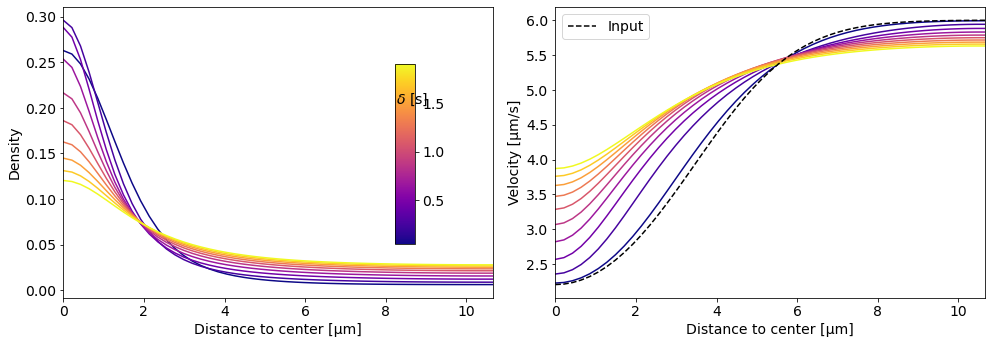

In [5]:
colorwave = cm.plasma(np.linspace(0, 1, length))
start = int(nx/2)

fig=plt.figure(1, figsize = (14,5) )
ax1 = plt.subplot(1,2,1)
for i in range(length):
    plt.plot(saveall[start:,i,0]*1e6,saveall[start:,i,2]*1e-6,color=colorwave[i])
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Density') 
ax1.set_xlim([0,boundaryradius*1e6])

ax2 = plt.subplot(1,2,2)
for i in range(length):
    plt.plot(saveall[start:,i,0]*1e6,saveall[start:,i,1]*1e6,color=colorwave[i])
plt.plot(xarray1*1e6, varray1*1e6,'k--',label='Input')
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Velocity [µm/s]') 
ax2.set_xlim([0,boundaryradius*1e6])
ax2.legend()

plt.tight_layout()
data = np.linspace(delaywave[0], delaywave[-1], length).reshape(length, 1)
im = ax.imshow(data, cmap='plasma')       #plot the colorbar
divider = make_axes_locatable(ax1)
cax = fig.add_axes([0.4, 0.3, 0.02, 0.5])
plt.colorbar(im, cax=cax)
plt.text(0.1,1.5,r'$\delta}$ [s]')

plt.savefig('Comparison.svg', format='svg')
plt.savefig('Comparison.pdf', format='pdf')
plt.show()

## Load and alayze experimental data

In [6]:
number = length
filestart = '1'
fileend = '50'
folder = './DataExperiment'

datageneral = np.loadtxt(r''+str(folder)+'/DataGeneral'+str(filestart)+'.txt')
dt = datageneral[0]
videosize = datageneral[3]
binning = 1
frametransfer = False
flashtime = 0.01
verticalshift = 1.9176e-6
dtprogram = 6.3e-3
dtcamtoPC = 1e-3
dtPCtoADwin = 1e-3

folder = './DataExperiment/DataImportant'     #Load from that folders
folder3 = './DataExperiment/DataRadial'
num = int(fileend)-int(filestart)+1
dataimportant = np.loadtxt(r''+str(folder)+'/DataImportant'+str(filestart)+'.txt')
lengthimportant = len(dataimportant)        #initialize size of the arrays
expallimportant = np.zeros((lengthimportant,num))          
data4 = np.loadtxt(r''+str(folder3)+'/DataRadial'+str(filestart)+'.txt')
radiallength = len(data4)
radialrows = len(data4[0,:])
expdataradial = np.zeros((radiallength,radialrows,num))

for i in range(num):                          #Load data
    if i < 36: file = int(int(filestart)+i)
    else: file = int(int(filestart)+i+1)
    data2 = np.loadtxt(r''+str(folder)+'/DataImportant'+str(file)+'.txt')
    #0 - mean distance to center, 1 - boundary hits, 2 - mean angle change, 3 - countin, 4 - noise, 5 - delay, 
    #6 - reorientation time, 7 - mean of the propability, 8 - sd density, 9/10 - Drot/err, 11/12 - Drotexp/err, 
    #13/14 - ptime/err, 15/16 - plength/err, 17/18 - radialdistmore in/out, 19 vmax, 
    #20 meantime, 21 meanprob, 22 notone, 23 zero 
    expallimportant[:,i] = data2

    #0 - xpos; 1 - mean v; 2 - std v; 3 - mean v_out; 4 - std v_out; 5 - mean v_in; 6 - std v_in
    #7 - density; 8 - v diff; 9 - v diff std; 10 - Drift; 11 - std Drift; 12 - % inwards; 13 - N*v_in - N * v_out
    data4 = np.loadtxt(r''+str(folder3)+'/DataRadial'+str(file)+'.txt')
    expdataradial[:,:,i] = data4

expallimportant[5,6] = 25                      #Correct some wrong saved data
expallimportant[5,7] = 29 
expallimportant[5,12] = 9 
expallimportant[5,36:39] -= 1
expallimportant[5,40:49] -= 1
expallimportant[4,39] = 17
    
rows = 1; expsteps = 1; check = True
for i in range(1,num):
    if check == True:
        if expallimportant[4,i] == expallimportant[4,i-1]: expsteps += 1
    if expallimportant[4,i] != expallimportant[4,i-1]:
            check = False
            rows += 1
print('steps = ',expsteps,' - rows = ',rows)
dtframetransfer = videosize/binning * verticalshift          #Calculate delay
dtreadout = (1032/27e6+verticalshift)*videosize/binning
dtexphalf = flashtime/2
dttotal = dtexphalf + dtframetransfer + dtreadout + dtcamtoPC + dtprogram + dtPCtoADwin
delaytest = np.zeros(num)
for i in range(num): delaytest[i] = dttotal + (expallimportant[5,i]-1)*dt
timewave = np.zeros(num)
for i in range(num): timewave[i] = 51e-3*10000*i/(60*60) 
    
test = np.linspace(0,boundaryradius,radiallength+1)
radius = np.zeros(radiallength)
for i in range(radiallength): expdataradial[i,0,:] = (test[i]+test[i+1])/2
    
expmeandrot = np.zeros(num)                                  #Calculate average tau_r
for i in range(rows):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try: expmeandrot[i*expsteps:i*expsteps+expsteps] = stat.mode(expallimportant[6,i*expsteps:i*expsteps+expsteps])
        except: expmeandrot[i*expsteps:i*expsteps+expsteps] = np.nanmean(expallimportant[6,i*expsteps:i*expsteps+expsteps])
            
comparearray = np.zeros(rows); expdelaywave = np.zeros(expsteps)  #Save average tau_r
for i in range(rows): comparearray[i] = abs(expmeandrot[i*expsteps]-tauR)
for i in range(expsteps): expdelaywave[i] = delaytest[i]
expfittingrow = np.argmin(comparearray)

expsmoothflow = np.zeros((radiallength,number))              #Smooth v_diff from experiment
count = expfittingrow*expsteps
for i in range(number):
    expsmoothflow[0,i] = (expdataradial[0,8,count] + 0.5*expdataradial[1,8,count])/1.5
    expsmoothflow[-1,i] = (0.5*expdataradial[-2,8,count] + expdataradial[-1,8,count])/1.5
    for j in range(1,radiallength-1): expsmoothflow[j,i] = (0.5*expdataradial[j-1,8,count]+expdataradial[j,8,count]+0.5*expdataradial[j+1,8,count])/2
    count += 1

expmaxpoints = np.zeros((number,2))                          #Find extremas of v_diff
count = expfittingrow*expsteps
for i in range(number):
    expmaxpoints[i,1] = np.max(expsmoothflow[1:-1,i])
    check = np.argmax(expsmoothflow[1:-1,i])
    expmaxpoints[i,0] = expdataradial[check+1,0,0]
    count += 1

test = np.linspace(0,boundaryradius,radiallength+1)          #Correct radial position
radius = np.zeros(radiallength)
for i in range(radiallength): expdataradial[i,0,:] = (test[i]+test[i+1])/2

steps =  10  - rows =  5


# Load and analyze data from numerical simulation

In [50]:
start = '0'
end = '49'
folder = './DataSimulation/DataImportant'          #Load from that folders
folder2 = './DataSimulation/DataRadial'
num = int(end)-int(start)+1

data3 = np.loadtxt(r''+str(folder)+'/DataImportant'+str(start)+'.txt')
importantlength = len(data3)                       #Initialize arrays
simallimportant = np.zeros((importantlength,num))           

data4 = np.loadtxt(r''+str(folder2)+'/DataRadial'+str(start)+'.txt')
radiallength = len(data4)
radialrows = len(data4[0,:])
simdataradial = np.zeros((radiallength,radialrows,num))

for i in range(num):                               #Load data
    number2 = int(int(start)+i)
    data2 = np.loadtxt(r''+str(folder)+'/DataImportant'+str(number2)+'.txt')
    #0 - mean distance         1 - paths  2 - angle change; 3 - inside; 4 - noise; 5 - delay; 6 - tau_r; 
    #7 - mean rho; 8 - tau_r 2; 9/10 - Drot/err; 11/12 - Drot2/err; 13/14 - ptime/err; 15/16 - rlength/err; 
    #17/18 - morein/out; 19 - maxv; 20 - meantime; 21 - meanprob
    simallimportant[:,i] = data2
    
    #0 - xpos; 1 - mean v; 2 - std v; 3 - mean v_out; 4 - std v_out; 5 - mean v_in; 6 - std v_in
    #7 - density; 8 - v diff; 9 - v diff std; 10 - Drift; 11 - std Drift; 12 - % inwards; 13 - N*v_in - N * v_out
    data4 = np.loadtxt(r''+str(folder2)+'/DataRadial'+str(number2)+'.txt')
    simdataradial[:,:,i] = data4

rows = 1; simsteps = 1; check = True
for i in range(1,num):
    if check == True:
        if simallimportant[4,i] == simallimportant[4,i-1]: simsteps += 1
    if simallimportant[4,i] != simallimportant[4,i-1]:
            check = False
            rows += 1
print('steps = ',simsteps,' - rows = ',rows)

iterationtime = dtcycle; programtime = dtprogram
delaytest = np.zeros(num)                           #Calculate delay
for i in range(num): delaytest[i] = iterationtime*(simallimportant[5,i]-1)+dt/2+videosize*1.9176e-6+(1032/27e6+1.9176e-6)*videosize+programtime*1e-3+1e-3*2       
simtimewave = np.zeros(num)
for i in range(num): simtimewave[i] = 51e-3*10000*i/(60*60) 
    
simmeandrot = np.zeros(num)                         #Calculate average tau_R
for i in range(rows):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try: simmeandrot[i*simsteps:i*simsteps+simsteps] = stat.mode(simallimportant[6,i*simsteps:i*simsteps+simsteps])
        except: simmeandrot[i*simsteps:i*simsteps+simsteps] = np.mean(simallimportant[6,i*simsteps:i*simsteps+simsteps])

comparearray = np.zeros(rows); simdelaywave = np.zeros(simsteps)
for i in range(rows): comparearray[i] = abs(simmeandrot[i*simsteps]-tauR)
for i in range(simsteps): simdelaywave[i] = delaytest[i]
simfittingrow = np.argmin(comparearray)

test = np.linspace(0,boundaryradius,radiallength+1)
radius = np.zeros(radiallength)
for i in range(radiallength): simdataradial[i,0,:] = (test[i]+test[i+1])/2
    
simmaxpoints = np.zeros((number,2))          #Find the maximum points of the flow
count = simfittingrow*simsteps
for i in range(number):
    simmaxpoints[i,1] = np.max(simdataradial[:,8,count])
    check = np.argmax(simdataradial[:,8,count])
    simmaxpoints[i,0] = simdataradial[check,0,count]
    count += 1

stophere = 3
dataend = (expdataradial[stophere,0,0] + expdataradial[stophere-1,0,0])/2 #mittel zwischen 2-3

expdensity = np.zeros(expsteps)                              #Calculate the percentage the particle spends in the inner quarter
expdx = expdataradial[1,0,0] - expdataradial[0,0,0]
count = expfittingrow*expsteps
for i in range(expsteps):
    expdensity[i] = sum(expdataradial[:stophere,7,count]*expdx)/sum(expdataradial[:,7,count]*expdx)
    count += 1

count = 0; check = True
while check == True:
    if simdataradial[count,0,0] >= dataend: 
        check = False
        simend = count
    else: count += 1
simdensity = np.zeros(simsteps)                           #Calculate the percentage the particle spends in the inner quarter
simdx = simdataradial[1,0,0] - simdataradial[0,0,0]       #Simulation
count = simfittingrow*simsteps
for i in range(simsteps):
    simdensity[i] = sum(simdataradial[:3,7,count]*simdx)/sum(simdataradial[:,7,count]*simdx)
    count += 1
    
starthere = int(nx/2)
theodensity = np.zeros(number)                            #Calculate the percentage the particle spends in the inner quarter
count = starthere; check = True                                   #Theory
while check == True:
    if x[count] >= 1e-6:#dataend:
        #print(x[count],dataend,count)
        check = False
        theoend = count
    else: count += 1
for i in range(number): 
    theodensity[i] = sum(saveall[starthere:theoend,i,2])/sum(saveall[starthere:,i,2])
    #print(round(sum(saveall[starthere:theoend,i,2]),3),' - ',round(sum(saveall[starthere:,i,2]),3))

steps =  10  - rows =  5


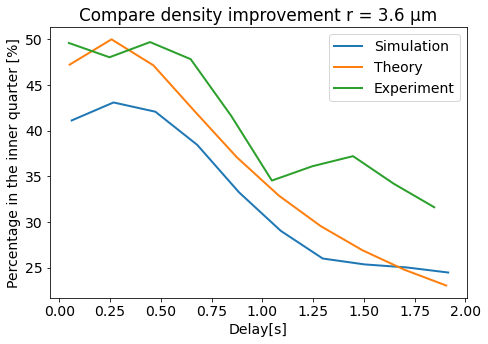

In [51]:
fig, ax = plt.subplots(figsize=(7,5)) 
#fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)
ax2 = plt.subplot(1,1,1)                  #plotv profiles
ax2.plot(simdelaywave,simdensity*100,linewidth=2,label='Simulation')
ax2.plot(delaywave,theodensity*100,linewidth=2,label='Theory')
ax2.plot(expdelaywave,expdensity*100,linewidth=2,label='Experiment')
ax2.set_xlabel('Delay[s]')
ax2.set_ylabel('Percentage in the inner quarter [%]')
ax2.set_title('Compare density improvement r = '+str(round(dataend*1e6,1))+' µm')
ax2.legend()

plt.tight_layout() 
plt.savefig('Density change lower r = '+str(round(dataend*1e6,1))+'.pdf', format='pdf')
plt.savefig('Density change lower r = '+str(round(dataend*1e6,1))+'.svg', format='svg')
plt.show()

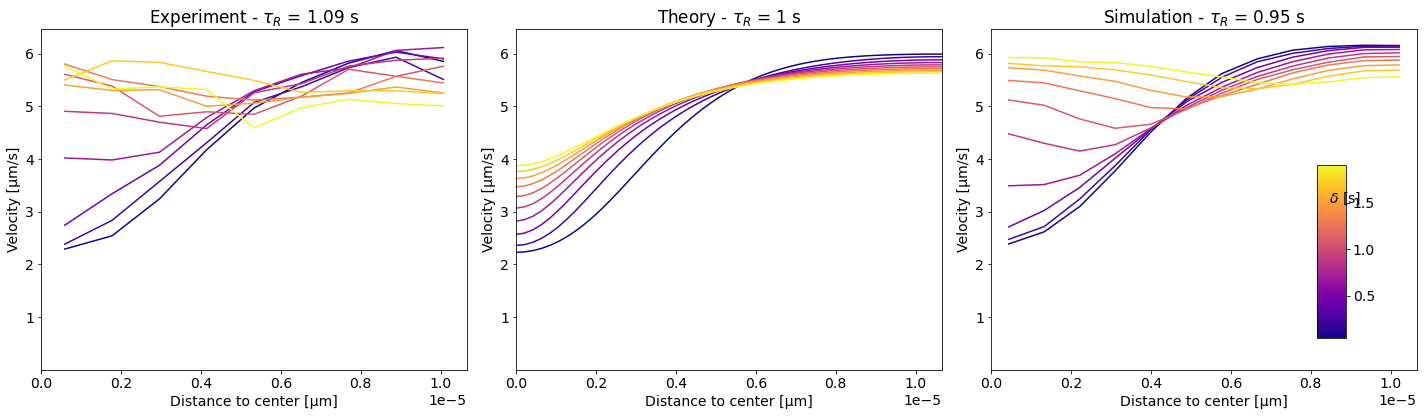

In [10]:
extremaarray = np.zeros((3,2))
extremaarray[0,0] = np.amin(expdataradial[:,1,expfittingrow*expsteps:expfittingrow*expsteps+expsteps])
extremaarray[1,0] = np.amin(simdataradial[:,1,simfittingrow*simsteps:simfittingrow*simsteps+simsteps])
extremaarray[2,0] = np.amin(saveall[:,:,1])
extremaarray[0,1] = np.amax(expdataradial[:,1,expfittingrow*expsteps:expfittingrow*expsteps+expsteps])
extremaarray[1,1] = np.amax(simdataradial[:,1,simfittingrow*simsteps:simfittingrow*simsteps+simsteps])
extremaarray[2,1] = np.amax(saveall[:,:,1])
minvalue = 0.9*np.min(extremaarray[:,0])
maxvalue = 1.05*np.max(extremaarray[:,1])

fig, ax = plt.subplots(figsize=(20,6)) 
#fig.suptitle('Compare velocity profiles', fontsize=26)
ax1 = plt.subplot(1,3,1)
colorwave = cm.plasma(np.linspace(0, 1, expsteps))
count = expfittingrow*expsteps
for i in range(expsteps):
    ax1.plot(expdataradial[:,0,count],expdataradial[:,1,count],color=colorwave[i])
    count += 1
ax1.set_xlabel('Distance to center [µm]')
ax1.set_ylabel('Velocity [µm/s]') 
ax1.set_xlim([0,boundaryradius])
ax1.set_ylim([minvalue,maxvalue])
ax1.set_title(r'Experiment - $\tau_{R}$ = '+str(round(expmeandrot[expfittingrow*expsteps],2))+' s')
                            
ax2 = plt.subplot(1,3,2)
colorwave = cm.plasma(np.linspace(0, 1, number))
for i in range(number):
    ax2.plot(x,saveall[:,i,1]*1e6,color=colorwave[i])
ax2.set_xlabel('Distance to center [µm]')
ax2.set_ylabel('Velocity [µm/s]') 
ax2.set_xlim([0,boundaryradius])
ax2.set_ylim([minvalue,maxvalue])
ax2.set_title(r'Theory - $\tau_{R}$ = '+str(tauR)+' s')

ax3 = plt.subplot(1,3,3)
colorwave = cm.plasma(np.linspace(0, 1, simsteps))
count = simfittingrow*simsteps
for i in range(number):
    ax3.plot(simdataradial[:,0,count],simdataradial[:,1,count],color=colorwave[i])
    count += 1
ax3.set_xlabel('Distance to center [µm]')
ax3.set_ylabel('Velocity [µm/s]') 
ax3.set_xlim([0,boundaryradius])
ax3.set_ylim([minvalue,maxvalue])
ax3.set_title(r'Simulation - $\tau_{R}$ = '+str(round(simmeandrot[simfittingrow*simsteps],2))+' s')

plt.tight_layout() 
data = np.linspace(delaywave[0], delaywave[-1], number).reshape(number, 1)
im3 = ax.imshow(data, cmap='plasma')
divider = make_axes_locatable(ax3)
cax3 = fig.add_axes([0.92, 0.2, 0.02, 0.4])
plt.colorbar(im3, cax=cax3)
plt.text(0.8,1.5,r'$\delta$ [s]')
plt.savefig('Fig7.pdf', format='pdf')
plt.savefig('Compare velocity profiles.pdf', format='pdf')
plt.savefig('Compare velocity profiles.svg', format='svg')
plt.show()

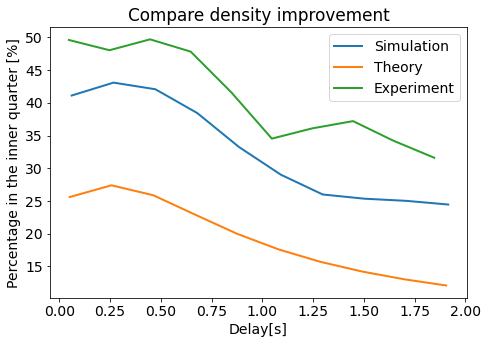

In [11]:
fig, ax = plt.subplots(figsize=(7,5)) 
#fig.suptitle(r'$\tau_{r} = $'+str(taur)+' s - boundary factor = '+str(boundaryparameter), fontsize=16)
ax2 = plt.subplot(1,1,1)                  #plotv profiles
ax2.plot(simdelaywave,simdensity*100,linewidth=2,label='Simulation')
ax2.plot(delaywave,densitysave*100,linewidth=2,label='Theory')
ax2.plot(expdelaywave,expdensity*100,linewidth=2,label='Experiment')
ax2.set_xlabel('Delay[s]')
ax2.set_ylabel('Percentage in the inner quarter [%]')
ax2.set_title('Compare density improvement')
ax2.legend()

plt.tight_layout() 
plt.savefig('Fig5.pdf', format='pdf')
plt.show()

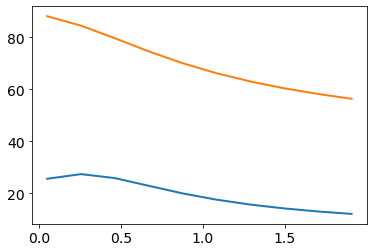

In [12]:
plt.plot(delaywave,densitysave*100,linewidth=2,label='Theory')
plt.plot(delaywave,theodensity*100,linewidth=2,label='Theory')

In [13]:
theodensity

array([0.88154646, 0.84526696, 0.79695236, 0.74653684, 0.70097111,
       0.6625177 , 0.63075916, 0.60449713, 0.58253664, 0.56389469])